# ResNet50

<a id='top'.</a>
[Table of contents](#bottom)

- [Initialization](#intro)
- [Data augmentation](#da)<a id='dl'.</a>
- [Modeling](#mobilenet)
    - [Base model](#dl)<a id='dl'.</a>
    - [Generating features](#dl)<a id='dl'.</a>
    - [Top model](#dl)<a id='dl'.</a>
    
[Table of contents](#top) [Bottom](#bottom)

<a id='intro'.</a>

## Initialization

In [7]:
import sys
sys.path.append('../utils/')

import libraries
from libraries import *
import utils_functions
from utils_functions import *

%matplotlib inline

reload(libraries)
from libraries import *
reload(utils_functions)
from utils_functions import *

# checking
print(get_available_gpus())
print(psutil.virtual_memory())
print(keras.__version__)

['/gpu:0']
svmem(total=64390926336, available=30719143936, percent=52.3, used=33208766464, free=29727870976, active=33218158592, inactive=721567744, buffers=49229824, cached=1405059072, shared=272429056)
2.0.6


#### Data loading

In [8]:
model = 'resnet_50'

# output directories
output = '../output'
models = 'models'
model_output = join(join(output, models), model)
model_output_weights = join(model_output, 'weights')

if not os.path.exists(output): os.mkdir(output)
if not os.path.exists(model_output): os.mkdir(model_output)
if not os.path.exists(model_output_weights): os.mkdir(model_output_weights)
    
# general variables
target_size = (256, 256) #(512, 512)
target_size_rn50 = (224, 224)
num_classes = 1
input_shape = target_size + (3,)
input_shape_rn050 = target_size_rn50 + (3,)

path='../../data/sushi_or_sandwich/'

In [9]:
x_train, y_train, x_test, y_test, mean_set, std_set = \
load_data(path=path, target_size=target_size, output_folder=output)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, mean_set, std_set)

Loading compressed data..
(640, 256, 256, 3) (640,) (160, 256, 256, 3) (160,) None None


In [10]:
# checking
# %timeit -n 1 load_data(path=path)
# %timeit for i in range(1): load_data(path=path, pil=True, output_folder=output)

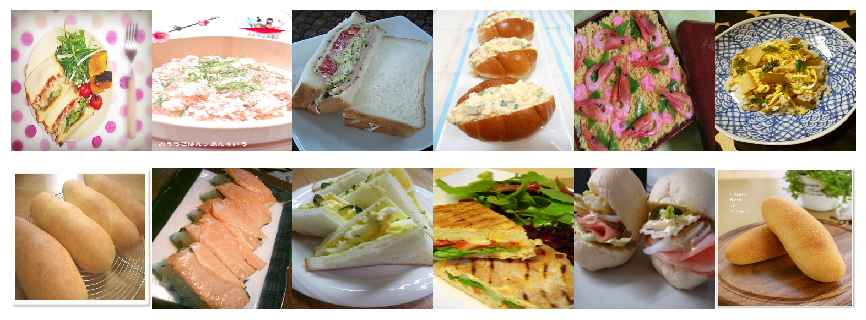

[0.0, 1.0, 0.0, 0.0, 1.0, 1.0]
[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]


In [11]:
plot_images(x_train[:12]); print(list(y_train[:6])); print(list(y_train[6:12]))

[Table of contents](#top) [Bottom](#bottom)

## Data augmentation

The process of data augmentation is performed by the following function contained in utils.py. It generates a set of ~2000 different data augmentation generators by iterating over an customizable value range for the following parameters/functions provided by the keras within the DataImageGenerator class:
- rotation_range
- width_shift_range     
- height_shift_range      
- shear_range             
- zoom_range              
- channel_shift_range        
- zca_whitening
- fill_mode                  
- horizontal_flip
- vertical_flip

Additionally it performs cropping of the images through the 'preprocessing_function'.

An example  of the images produced by a randomly selected generator is shown below.

Total number of available aug. data generators:  288
Selected number of aug. data generators:  288


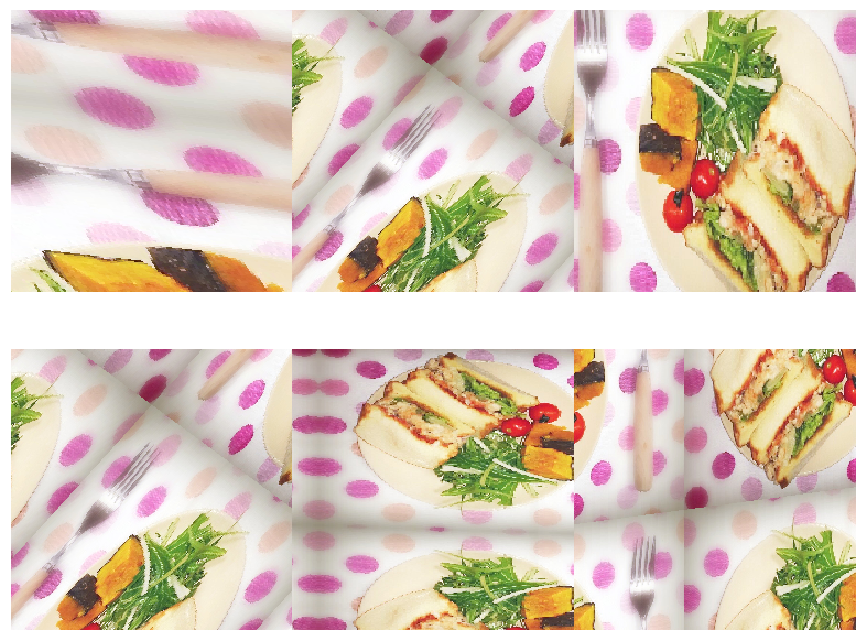

In [12]:
# 1. setting generators
# n_gen = 100
ad_gens = aug_data_generators(model)
len(ad_gens)
# 2. saving a 120-image sample and plotting a sample
save_aug_data_sample(ad_gens, model, target_size, path)

[Table of contents](#top) [Bottom](#bottom)

## Modelling

##### 0.0. Setting the base model

In [13]:
input_shape = x_train.shape[1:]

bm = ResNet50(include_top=False, weights='imagenet', input_shape=input_shape)

##### 0.1. Generating features

In [30]:
# calculates the features/output of the selected base model

data={'x_train':x_train, 'y_train':y_train, 'x_test':x_test, 'y_test':y_test}

x_adf_train, y_adf_train, x_adf_test, y_adf_test = \
generate_aug_data_features(bm, ad_gens, data, join(output, model), batch_size=16, iters=1, verbose=False)

print(x_adf_train.shape, y_adf_train.shape, x_adf_test.shape, y_adf_test.shape)

Loading compressed features..
(64000, 1, 1, 2048) (64000,) (16000, 1, 1, 2048) (16000,)


##### 0.2. Setting and training a top model

In [54]:
# 0. setting up optimizers:
sgd = SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)
adam = Adam()

# 1. setting callbacks
# cyclical lr
# clr_triangular = CyclicLR(mode='triangular')
# clr_triangular = CyclicLR(mode='triangular2')
# clr_triangular = CyclicLR(mode='exp_range', gamma=0.99994)
# clr_triangular._reset()
# clr_triangular._reset(new_base_lr=0.003, new_max_lr=0.009)

# clr = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
# clr_triangular = CyclicLR(scale_fn=clr, scale_mode='cycle')
# clr = lambda x: 1/(5**(x*0.0001))
# clr_triangular = CyclicLR(scale_fn=clr, scale_mode='iterations')

callbacks = []

c_file = join(join(output, model), 'top_model_{epoch:02d}-{val_loss:.2f}.hdf5')

checkpoint = ModelCheckpoint(c_file, monitor='val_loss', verbose=1,
                             save_best_only=True, save_weights_only=True, mode='min')
callbacks.append(checkpoint)

l_file = join(join(output, model), 'top_model.log')
csv_logger = CSVLogger(l_file)

callbacks.append(csv_logger)

# def schedule(epoch):
#     if epoch < 15:
#         return .01
#     elif epoch < 28:
#         return .002
#     else:
#         return .0004
# lr_scheduler = LearningRateScheduler(schedule)

# plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

In [63]:
# dropout percentage
p = 0.8

top_m = Sequential([
        BatchNormalization(input_shape=bm.output_shape[1:]),
        Flatten(),
        Dropout(p),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(1, activation='sigmoid')])

# top_m.load_weights(join(model, 'top_m_675_060.h5'))

top_m.compile(Adam(), loss='binary_crossentropy', 
              metrics=['accuracy', recall, precision, fmeasure])

# top_m.fit(X, Y, validation_split=0.33, epochs=150, batch_size=10, callbacks=callbacks_list, verbose=0)
# top_m.evaluate(x_adf_test, y_adf_test, batch_size=batch_size)

In [67]:
top_m.optimizer.lr = 0.000001; print(top_m.optimizer.lr)

batch_size = 128
epochs = 10

top_m_h = top_m.fit(x_adf_train, y_adf_train, batch_size=batch_size, epochs=epochs,                  
                    validation_data=(x_adf_test, y_adf_test),
                    callbacks=callbacks)

1e-05
Train on 64000 samples, validate on 16000 samples
Epoch 1/10
64000/64000 [==============================] - 6s - loss: 0.3026 - acc: 0.8655 - recall: 0.8656 - precision: 0.8714 - fmeasure: 0.8670 - val_loss: 0.3392 - val_acc: 0.8526 - val_recall: 0.8120 - val_precision: 0.8633 - val_fmeasure: 0.8360
Epoch 2/10
64000/64000 [==============================] - 6s - loss: 0.3047 - acc: 0.8657 - recall: 0.8677 - precision: 0.8706 - fmeasure: 0.8674 - val_loss: 0.3412 - val_acc: 0.8504 - val_recall: 0.7812 - val_precision: 0.8824 - val_fmeasure: 0.8279
Epoch 3/10
64000/64000 [==============================] - 6s - loss: 0.3008 - acc: 0.8668 - recall: 0.8651 - precision: 0.8742 - fmeasure: 0.8681 - val_loss: 0.3408 - val_acc: 0.8506 - val_recall: 0.8139 - val_precision: 0.8584 - val_fmeasure: 0.8347
Epoch 4/10
64000/64000 [==============================] - 6s - loss: 0.3002 - acc: 0.8683 - recall: 0.8690 - precision: 0.8740 - fmeasure: 0.8698 - val_loss: 0.3409 - val_acc: 0.8522 - val_re

In [43]:
weights_file = 'top_m_%.4f_%.4f' % (top_m_h.history['val_loss'][0], top_m_h.history['val_acc'][0])
top_m.save_weights(join(model_output_weights, weights_file))

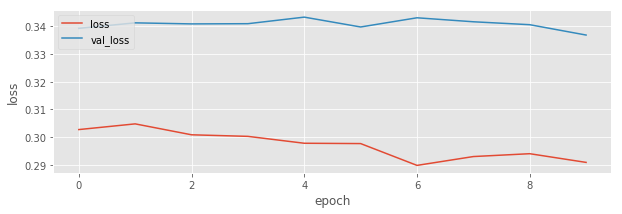

In [69]:
plot_hist(top_m_h, 'loss')
# plt.plot(clr_triangular.history['iterations'], clr_triangular.history['lr'])

##### 0.2.1. Setting and training alternative top models

In [59]:
p = 0.9

top_m0 = Sequential([
        BatchNormalization(input_shape=bm.output_shape[1:]),
        Flatten(),
        Dense(1024, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(p),
        Dense(1, activation='sigmoid')])

top_m1 = Sequential([
        BatchNormalization(input_shape=bm.output_shape[1:]),
        Dense(1024),
        BatchNormalization(),
        Activation('relu'),
        Dropout(p),
        Flatten(),
        Dense(1, activation='sigmoid')])

top_m2 = Sequential([
        BatchNormalization(input_shape=bm.output_shape[1:]),
        Flatten(),
        Dense(1, activation='sigmoid')])

top_m1.summary()

top_m1.compile(Adam(), loss='binary_crossentropy', 
              metrics=['accuracy', recall, precision, fmeasure])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_24 (Batc (None, 1, 1, 2048)        8192      
_________________________________________________________________
flatten_9 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 2049      
Total params: 10,241
Trainable params: 6,145
Non-trainable params: 4,096
_________________________________________________________________


In [57]:
top_m1.optimizer.lr = 0.001; print(top_m1.optimizer.lr)

batch_size = 128
epochs = 10

top_m1_h = top_m1.fit(x_adf_train, y_adf_train, batch_size=batch_size, epochs=epochs,                  
                      validation_data=(x_adf_test, y_adf_test),
                      callbacks=callbacks)

AttributeError: 'Sequential' object has no attribute 'optimizer'

In [62]:
weights_file = 'top_m1_%.4f_%.4f' % (top_m1_h.history['val_loss'][0], top_m1_h.history['val_acc'][0])
top_m.save_weights(join(model_output_weights, weights_file))

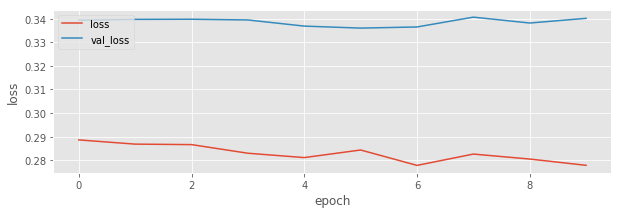

In [63]:
plot_hist(top_m1_h, 'loss')

In [60]:
top_m2.optimizer.lr = 0.001; print(top_m2.optimizer.lr)

batch_size = 128
epochs = 10

top_m2_h = top_m2.fit(x_adf_train, y_adf_train, batch_size=batch_size, epochs=epochs,                  
                      validation_data=(x_adf_test, y_adf_test),
                      callbacks=callbacks)

0.001
Train on 64000 samples, validate on 16000 samples
Epoch 1/10
64000/64000 [==============================] - 4s - loss: 0.2882 - acc: 0.8716 - recall: 0.8720 - precision: 0.8770 - fmeasure: 0.8730 - val_loss: 0.3621 - val_acc: 0.8442 - val_recall: 0.8346 - val_precision: 0.8304 - val_fmeasure: 0.8318
Epoch 2/10
64000/64000 [==============================] - 3s - loss: 0.2024 - acc: 0.9163 - recall: 0.9161 - precision: 0.9205 - fmeasure: 0.9171 - val_loss: 0.3550 - val_acc: 0.8528 - val_recall: 0.8448 - val_precision: 0.8395 - val_fmeasure: 0.8412
Epoch 3/10
64000/64000 [==============================] - 3s - loss: 0.1836 - acc: 0.9248 - recall: 0.9254 - precision: 0.9284 - fmeasure: 0.9257 - val_loss: 0.3674 - val_acc: 0.8508 - val_recall: 0.8539 - val_precision: 0.8298 - val_fmeasure: 0.8408
Epoch 4/10
64000/64000 [==============================] - 3s - loss: 0.1737 - acc: 0.9290 - recall: 0.9286 - precision: 0.9326 - fmeasure: 0.9297 - val_loss: 0.3795 - val_acc: 0.8452 - val_re

In [ ]:
weights_file = 'top_m2_%.4f_%.4f' % (top_m2_h.history['val_loss'][0], top_m2_h.history['val_acc'][0])
top_m.save_weights(join(model_output_weights, weights_file))

In [ ]:
plot_hist(top_m2_h, 'loss')

##### 0.3. Training the whole model 

In [108]:
m = Model(bm.input, top_m(bm.output))

# for i in m1.layers: i.trainable = True
for layer in bm.layers[:153]:
    layer.trainable = False
for layer in bm.layers[153:]:
    layer.trainable = True

m.compile(Adam(), loss='binary_crossentropy', 
          metrics=['accuracy', recall, precision, fmeasure])

m.load_weights(join(model_output_weights, 'm_0.2732_0.9000'))
m.evaluate(x_test, y_test, batch_size=batch_size)

160/160 [==============================] - 3s     


[0.27243031524121764,
 0.88749999999999996,
 0.83988095521926875,
 0.9303571462631226,
 0.86676377058029175]

In [125]:
m.optimizer.lr = 0.00000000001; print(m.optimizer.lr)
batch_size = 8
epochs = 1
n_gen = 50

# s_plot_ix = list(np.random.randint(0, len(ad_gens), n_gen)); print(s_plot_ix)

# m_h_g = []
# for i in ad_gens:
#     adg_train = i.flow(x_train, y_train, batch_size=batch_size)
# #     adg_test = i.flow(x_train, y_train, batch_size=batch_size)

#     m_h = m.fit_generator(adg_train, x_train.shape[0]//batch_size, epochs=epochs, 
#                           validation_data=(x_test, y_test))
#     m_h_g.append(m_h)
#     print("Generator: ", i)

m_h = m.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, 
            validation_data=(x_test, y_test))

1e-11
Train on 640 samples, validate on 160 samples
Epoch 1/1
640/640 [==============================] - 17s - loss: 0.1249 - acc: 0.9547 - recall: 0.9629 - precision: 0.9573 - fmeasure: 0.9528 - val_loss: 0.2674 - val_acc: 0.8812 - val_recall: 0.8017 - val_precision: 0.8650 - val_fmeasure: 0.8047


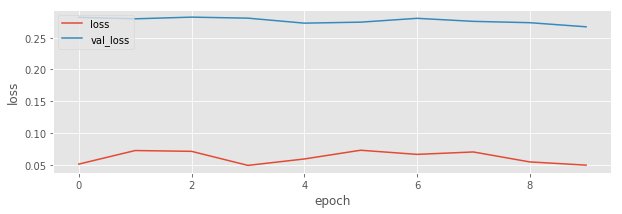

In [110]:
plot_hist(m_h, 'loss')

In [126]:
weights_file = 'm_%.4f_%.4f' % (m_h.history['val_loss'][0], m_h.history['val_acc'][0])
m.save_weights(join(model_output_weights, weights_file))

In [122]:
for _, i in enumerate(m.layers):
    print(_, i.name)

0 input_1
1 zero_padding2d_1
2 conv1
3 bn_conv1
4 activation_1
5 max_pooling2d_1
6 res2a_branch2a
7 bn2a_branch2a
8 activation_2
9 res2a_branch2b
10 bn2a_branch2b
11 activation_3
12 res2a_branch2c
13 res2a_branch1
14 bn2a_branch2c
15 bn2a_branch1
16 add_1
17 activation_4
18 res2b_branch2a
19 bn2b_branch2a
20 activation_5
21 res2b_branch2b
22 bn2b_branch2b
23 activation_6
24 res2b_branch2c
25 bn2b_branch2c
26 add_2
27 activation_7
28 res2c_branch2a
29 bn2c_branch2a
30 activation_8
31 res2c_branch2b
32 bn2c_branch2b
33 activation_9
34 res2c_branch2c
35 bn2c_branch2c
36 add_3
37 activation_10
38 res3a_branch2a
39 bn3a_branch2a
40 activation_11
41 res3a_branch2b
42 bn3a_branch2b
43 activation_12
44 res3a_branch2c
45 res3a_branch1
46 bn3a_branch2c
47 bn3a_branch1
48 add_4
49 activation_13
50 res3b_branch2a
51 bn3b_branch2a
52 activation_14
53 res3b_branch2b
54 bn3b_branch2b
55 activation_15
56 res3b_branch2c
57 bn3b_branch2c
58 add_5
59 activation_16
60 res3c_branch2a
61 bn3c_branch2a
62 ac

In [128]:
# m = Model(bm.input, top_m(bm.output))

# for i in m1.layers: i.trainable = True
for layer in bm.layers[:120]:
    layer.trainable = False
for layer in bm.layers[120:]:
    layer.trainable = True

m.compile(Adam(), loss='binary_crossentropy', 
          metrics=['accuracy', recall, precision, fmeasure])

# m.load_weights(join(model_output_weights, 'm_0.2732_0.9000'))
# m.evaluate(x_test, y_test, batch_size=batch_size)

In [129]:
m.optimizer.lr = 0.0000000001; print(m.optimizer.lr)
batch_size = 128
epochs = 10

m_h = m.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, 
            validation_data=(x_test, y_test))

1e-10
Train on 640 samples, validate on 160 samples
Epoch 1/10
640/640 [==============================] - 19s - loss: 0.0371 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - fmeasure: 1.0000 - val_loss: 0.2685 - val_acc: 0.8812 - val_recall: 0.8219 - val_precision: 0.9040 - val_fmeasure: 0.8607
Epoch 2/10
640/640 [==============================] - 15s - loss: 0.0397 - acc: 0.9938 - recall: 0.9913 - precision: 0.9966 - fmeasure: 0.9939 - val_loss: 0.2688 - val_acc: 0.8812 - val_recall: 0.8219 - val_precision: 0.9040 - val_fmeasure: 0.8607
Epoch 3/10
640/640 [==============================] - 15s - loss: 0.0343 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - fmeasure: 1.0000 - val_loss: 0.2694 - val_acc: 0.8875 - val_recall: 0.8219 - val_precision: 0.9184 - val_fmeasure: 0.8673
Epoch 4/10
640/640 [==============================] - 15s - loss: 0.0338 - acc: 1.0000 - recall: 1.0000 - precision: 1.0000 - fmeasure: 1.0000 - val_loss: 0.2696 - val_acc: 0.8875 - val_recall: 0.8219 - v

##### 0.5. Visualizing and saving predictions

Prediction: 
 [ 1.  1.  1.]
Label: 
 [ 1.  1.  1.]


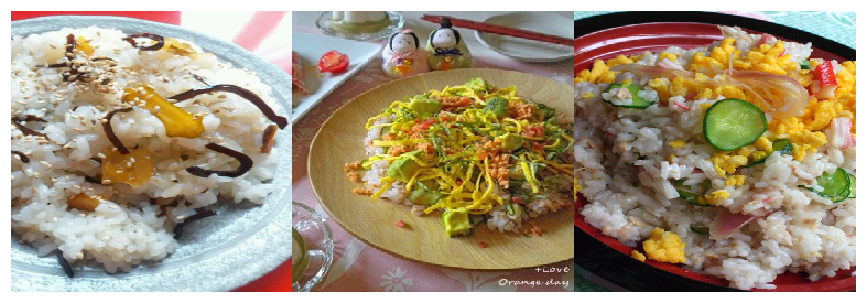

In [132]:
sample_ix = random.randint(0, x_test.shape[0])
print("Prediction: \n", np.round(m.predict(x_test[sample_ix:sample_ix+3])).ravel())
print("Label: \n", y_test[sample_ix:sample_ix+3])
plot_ims(x_test[sample_ix:sample_ix+3])

In [141]:
m_predictions = m.predict(x_test)
save_array(join(model_output, 'predictions'), m_predictions)

Prediction: 
 [ 0.96572614  0.93574345  0.99996531]
Label: 
 [ 1.  1.  1.]


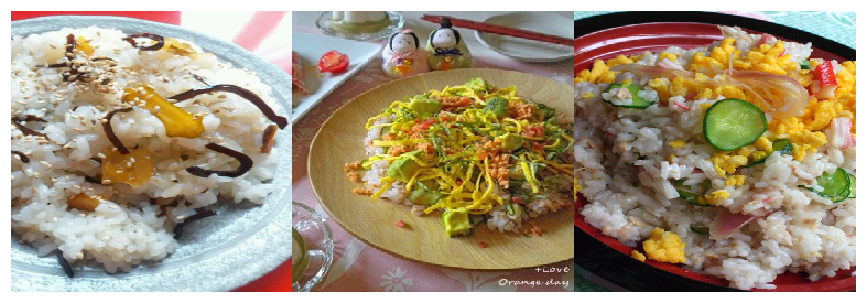

In [142]:
m_predictions = load_array(join(model_output, 'predictions'))
print("Prediction: \n", m_predictions[sample_ix:sample_ix+3].ravel())
print("Label: \n", y_test[sample_ix:sample_ix+3])
plot_ims(x_test[sample_ix:sample_ix+3])

[Table of contents](#top) [Bottom](#bottom)

##### Alternative base model

####  Initial Batchnorm Layer + ResNet50

In [207]:
initial_batchnorm = Sequential([BatchNormalization(input_shape=input_shape)])
# input_tensor = Input(tensor=initial_batchnorm.output)
_bm = ResNet50(include_top=False, weights='imagenet', input_shape=initial_batchnorm.output_shape[1:])
b_bm = Model(initial_batchnorm.input, _bm(initial_batchnorm.output))
b_bm.summary()

# keep selected top model as top_m

b_m = Model(b_bm.input, top_m(b_bm.output))

for layer in bm2.layers[:172]:
    layer.trainable = False
for layer in bm2.layers[172:]:
    layer.trainable = True

b_m.compile(Adam(), loss='binary_crossentropy', 
            metrics=['accuracy', recall, precision, fmeasure ])

ValueError: Operation 'init_55' has been marked as not fetchable.

In [ ]:
END